# Performance Factors Analysis (PFA)

This model is based on the paper called *Performance Factors Analysis - A New Alternative to Knowledge Tracing* by Pavlik, Cen & Koedinger (2009).
The paper proposes a new model for student learning that is based on the idea of performance factors, which are the underlying cognitive processes that influence a student's performance on a task. The model is designed to be more flexible and interpretable than traditional knowledge tracing models, and it has been shown to be effective in predicting student performance in a variety of educational contexts.

**Outline:**
1. **Introduction**: What is PFA and why use it?  
2. **Imports & Data Loading**  
3. **Merge Skill Labels**  
4. **Feature Engineering**: cumulative counts of successes (*S_{u,k}*) and failures (*F_{u,k}*) per student *u* and skill *k*.  
5. **Train PFA Models** (one logistic regression per skill)  
6. **Validate** on the held-out set  
7. **Test** on the test set  
8. **Analysis & Visualization**
9. **Conclusion**: Summary of findings and future work

## 1. Introduction

The **Performance Factors Analysis (PFA)** model measures the probability that a student will correctly answer an exercise based on his or her history of previous hits and misses on the same skill.
Instead of assuming a binary state of knowledge (as in BKT), PFA uses two main factors as predictors in a logistic regression model:
number of correct attempts at the skill $S_{u,k}^{<i}$ (how many times the learner has answered correctly on previous exercises of the same skill) and number of incorrect attempts at the skill $F_{u,k}^{<i}$ (how many times the learner has made errors on previous exercises of the same skill).

**PFA** is a logistic regression model where each student–skill interaction is predicted from:
$$
P(\text{correct}_{u,i}) = \sigma\!\bigl(\beta_{0,k} + \beta_{s,k}\,S_{u,k}^{<i} + \beta_{f,k}\,F_{u,k}^{<i}\bigr)
$$
where:
- $S_{u,k}^{<i}$: count of prior successes of user $u$ on skill $k$ before opportunity $i$.  
- $F_{u,k}^{<i}$: count of prior failures of user $u$ on skill $k$ before opportunity $i$.  
- $\beta_{0,k},\beta_{s,k},\beta_{f,k}$: model parameters for skill $k$.
  - $\beta_{0,k}$: intercept (baseline probability of success).
  - $\beta_{s,k}$: weight for the number of successes (positive influence).
  - $\beta_{f,k}$: weight for the number of failures (negative influence).  
- $\sigma$: logistic (sigmoid) function.

So, this model measures the probability of a correct answer based on the number of previous successes and failures. The model is trained on a dataset of student interactions with exercises, where each interaction is labeled with whether the student answered correctly or incorrectly. The model learns the parameters $\beta_{0,k}, \beta_{1,k}$ and $\beta_{2,k}$ for each skill $k$ based on the training data.
The model is then used to predict the probability of a correct answer for new student interactions with exercises, based on the number of previous successes and failures for each skill.

## 2. Imports & Data 

We import necessary libraries and load the preprocessed data.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Paths to training, validation, and test data
data_path = os.path.join("..", "..", "Data_Preprocessing", "data", "splits")

# Load pre-split data
train_df = pd.read_parquet(os.path.join(data_path, "train.parquet"))
val_df   = pd.read_parquet(os.path.join(data_path, "val.parquet"))
test_df  = pd.read_parquet(os.path.join(data_path, "test.parquet"))

# Path to the questions data
data_path = os.path.join("..", "..", "Data_Preprocessing", "data")
# We load only the necessary columns of questions_df
questions_df = pd.read_parquet(os.path.join(data_path, "questions_clean.parquet"))
questions = questions_df[['id', 'general_cat']].rename(columns={'id':'question_id'})

## 3. Merge Skill Labels

Bring the *general_cat* (skill) into each split. Drop any interactions without a skill label.

In [2]:
# First, we merge general_cat in each split. 'general_cat' represents the more general category of the question.
# We will use it to group the questions into skills.
def attach_skill(df):
    """ Attach the general category to the questions in the dataframe.
    Args:
        df (pd.DataFrame): DataFrame containing question_id.
    Returns:
        pd.DataFrame: DataFrame with the general category attached.
    """
    df2 = df.merge(questions, on='question_id', how='left')
    return df2[df2['general_cat'].notna()].copy()

# Merge the general category into each split
train_df = attach_skill(train_df)
val_df   = attach_skill(val_df)
test_df  = attach_skill(test_df)

print("Train interactions:", len(train_df), " Val:", len(val_df), " Test:", len(test_df))


Train interactions: 420867  Val: 89809  Test: 92496


## 4. Feature Engineering

For each interaction, compute:
- *succ_count*: number of prior correct responses on this skill by this student.
- *fail_count*: number of prior incorrect responses.

In [3]:
def build_pfa_features(df):
    """
    Build 'succ_count' and 'fail_count' features for the PFA model.
    Args:
        df (pd.DataFrame): DataFrame containing user interactions.
    Returns:
        pd.DataFrame: DataFrame with the additional features for PFA.
    """
    # sort chronologically
    df = df.sort_values(['user_id','general_cat','start_time']).copy()
    
    # shift-cumsum within each (user, skill)
    df['succ_shift'] = df.groupby(['user_id','general_cat'])['correct'].shift(1, fill_value=0).astype(int)
    df['fail_shift'] = (1 - df['correct'].astype(int)).groupby([df['user_id'], df['general_cat']]).shift(1, fill_value=0).astype(int)
    
    df['succ_count'] = df.groupby(['user_id','general_cat'])['succ_shift'].cumsum()
    df['fail_count'] = df.groupby(['user_id','general_cat'])['fail_shift'].cumsum()
    
    # drop helper cols
    return df.drop(columns=['succ_shift','fail_shift'])

train_feat = build_pfa_features(train_df)
val_feat   = build_pfa_features(val_df)
test_feat  = build_pfa_features(test_df)

# quick sanity check
cols = ['user_id', 'correct', 'general_cat', 'succ_count', 'fail_count']
print("train_feat dataframe:")
display(train_feat[cols].head().reset_index(drop=True))
print("val_feat dataframe:")
display(val_feat[cols].head().reset_index(drop=True))
print("test_feat dataframe:")
display(test_feat[cols].head().reset_index(drop=True))


train_feat dataframe:


,user_id,correct,general_cat,succ_count,fail_count
0,235,True,C,0,0
1,235,False,C,1,0
2,235,False,C,1,1
3,235,True,C,1,2
4,235,False,C,2,2


val_feat dataframe:


,user_id,correct,general_cat,succ_count,fail_count
0,362,True,C,0,0
1,362,True,C,1,0
2,362,True,C,2,0
3,362,True,C,3,0
4,362,True,C,4,0


test_feat dataframe:


,user_id,correct,general_cat,succ_count,fail_count
0,330,True,C,0,0
1,330,True,C,1,0
2,330,True,C,2,0
3,330,False,C,3,0
4,330,True,C,3,1


# 5.Defining the *PFA* class

Instead of relying on *sklearn.linear_model.LogisticRegression*, we will implement our own *PerformanceFactorAnalysis* class that:

1. **Initializes** the three parameters $\beta_{0,k},\beta_{s,k},\beta_{f,k}$.  
2. Defines the **sigmoid** helper $\sigma(x)$.  
3. Implements a **cost function** based on the *negative log‐likelihood* (equivalently binary cross‐entropy).  
4. Uses **batch gradient descent** to update $\beta_{0,k},\beta_{s,k},\beta_{f,k}$ on the training set:  
   - Compute predictions $p_i = \sigma(\beta_{0,k} + \beta_{s,k}\,S_{u,k}^{<i} + \beta_{f,k}\,F_{u,k}^{<i}\bigr)$.  
   - Compute the gradient of the loss w.r.t. each $\beta$.  
   - Update parameters: $\beta \leftarrow \beta - \eta\,\nabla_\beta$.  
5. Provides *predict_proba()* to return $\sigma(\cdot)$ and *predict(thresh=0.5)* to threshold at a chosen cutoff.

This from-scratch implementation gives full transparency over the PFA optimization process and lets us tune learning rate, regularization, number of iterations, and decision threshold by hand.  

In [4]:
class PerformanceFactorAnalysis:
    """ This class implements the PFA model. """
    def __init__(self, lr=0.01, n_iters=1000, alpha=1e-3, tol=1e-6, early_stopping=False):
        """
        This is the initialization of the PFA model.
        Args:
            lr (float): Learning rate for gradient descent.
            n_iters (int): Number of iterations for training.
            alpha (float): L2 regularization parameter.
            tol (float): Tolerance for early stopping.
            early_stopping (bool): Whether to use early stopping.
        """
        # learning rate, number of iterations
        self.lr = lr
        self.n_iters = n_iters
        self.alpha = alpha
        self.tol = tol
        self.early_stopping = early_stopping
        # parameters: beta0 (intercept), beta_s (success), beta_f (failure)
        self.beta0 = 0.0
        self.beta_s = 0.0
        self.beta_f = 0.0
        # loss history
        self.loss_history = []

    def _sigmoid(self, x):
        """ This method computes the sigmoid function.
        Args:
            x (array): Input array.
        Returns:
            array: Sigmoid of the input array.
        """
        return 1 / (1 + np.exp(-x))

    def _compute_loss(self, succ, fail, y):
        """ This method computes the loss function.
        Args:
            succ (array): Array of success counts.
            fail (array): Array of failure counts.
            y (array): Array of true labels (0/1).
        Returns:
            float: Computed loss.
        """
        z = self.beta0 + self.beta_s * succ + self.beta_f * fail
        p = self._sigmoid(z)
        # avoid log(0)
        eps = 1e-9
        # cross‐entropy + L2
        ce = - (y * np.log(p + eps) + (1-y) * np.log(1-p + eps)).mean()
        l2 = (self.alpha/2) * (self.beta_s**2 + self.beta_f**2 + self.beta0**2)
        return ce + l2

    def fit(self, X_succ, X_fail, y):
        """
        This method fits the PFA model to the data.
        Args:
        X_succ: array shape (n_samples,) count of previous successes
        X_fail: array shape (n_samples,) count of previous failures
        y:      array shape (n_samples,) 0/1 if correct
        """
        prev_loss = np.inf
        for it in range(self.n_iters):
            # linear prediction
            z = self.beta0 + self.beta_s * X_succ + self.beta_f * X_fail
            p = self._sigmoid(z)
            
            # gradients with L2
            error = p - y
            grad0 = error.mean() + self.alpha * self.beta0
            grad_s = (error * X_succ).mean() + self.alpha * self.beta_s
            grad_f = (error * X_fail).mean() + self.alpha * self.beta_f
            
            # update
            self.beta0 -= self.lr * grad0
            self.beta_s -= self.lr * grad_s
            self.beta_f -= self.lr * grad_f

            # compute loss
            loss = self._compute_loss(X_succ, X_fail, y)
            self.loss_history.append(loss)
            
            # early stopping
            if self.early_stopping and abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss

    def predict_proba(self, X_succ, X_fail):
        """
        This method predicts the probability of success.
        Args:
            X_succ: array shape (n_samples,) count of previous successes
            X_fail: array shape (n_samples,) count of previous failures
        Returns:
            array: Predicted probabilities of success.
        """
        z = self.beta0 + self.beta_s * X_succ + self.beta_f * X_fail
        return self._sigmoid(z)

    def predict(self, X_succ, X_fail, thresh=0.5):
        """
        This method predicts the success/failure based on a threshold.
        Args:
            X_succ: array shape (n_samples,) count of previous successes
            X_fail: array shape (n_samples,) count of previous failures
            thresh: float, threshold for classification
        Returns:
            array: Predicted labels (0/1).
        """
        return (self.predict_proba(X_succ, X_fail) >= thresh).astype(int)


## 6. Train PFA Models

We train a separate logistic regression for each skill \(k\), using features:
$$
X = [\; \mathrm{succ\_count},\;\mathrm{fail\_count}\;],\quad
y = \text{correct}
$$

We only fit skills with at least N interactions in training.

Trained PFA for skill=C, n=191837, final_loss=0.6409


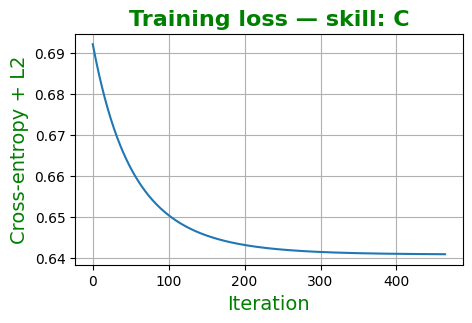

Trained PFA for skill=Databases & ORM, n=20645, final_loss=0.6626


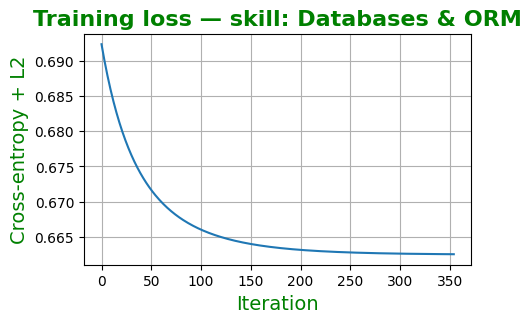

Trained PFA for skill=Javascript, n=12063, final_loss=0.6482


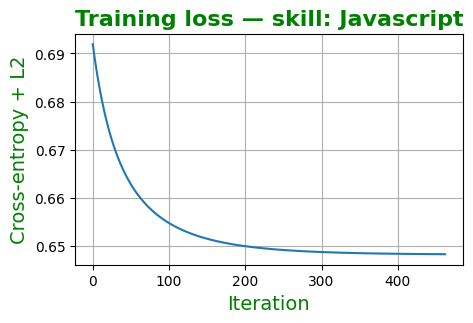

Trained PFA for skill=Math & Stats, n=23616, final_loss=0.5464


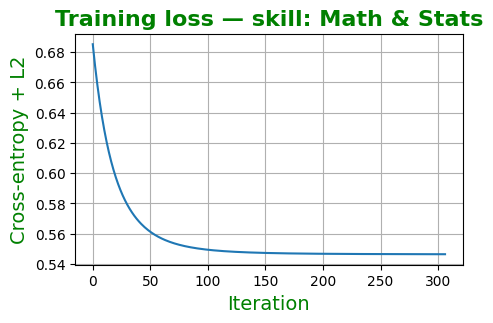

Trained PFA for skill=Programming & Basics, n=30487, final_loss=0.6576


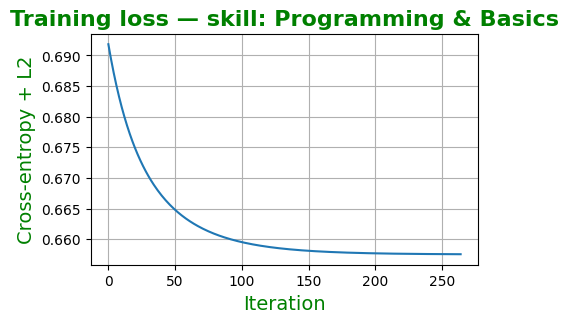

Trained PFA for skill=Python, n=54735, final_loss=0.6052


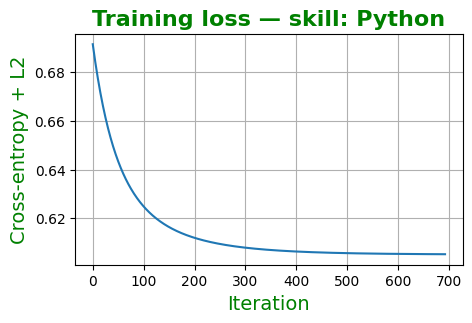

Trained PFA for skill=Shell, n=37467, final_loss=0.5664


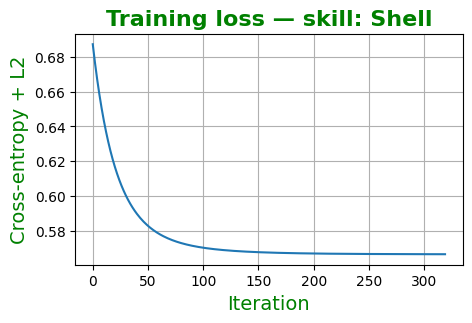

Trained PFA for skill=Web & Front-end, n=22016, final_loss=0.5906


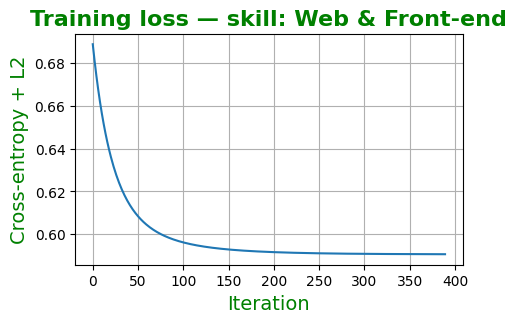

Trained PFA for skill=DevOps & Tools, n=9477, final_loss=0.5915


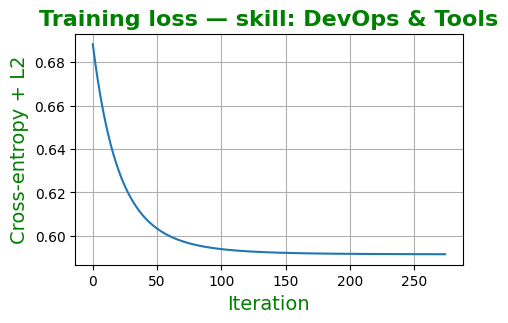

Trained PFA for skill=Networking & API, n=18524, final_loss=0.5479


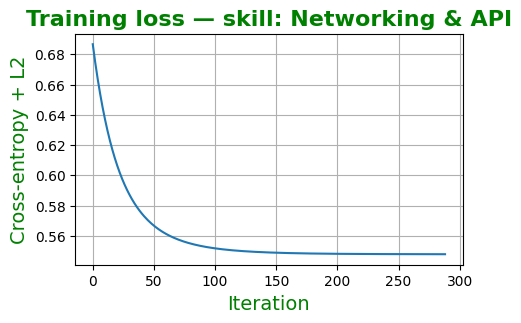

In [12]:
skills = train_feat['general_cat'].unique()
pfa_models = {}
min_interactions = 50

for skill in skills:
    sub = train_feat[train_feat['general_cat']==skill]
    if len(sub) < min_interactions:
        continue
    
    # Construir matriz de features y vectores target
    X = sub[['succ_count','fail_count']].values.astype(float)
    y = sub['correct'].astype(int).values

    # ESCALAR características para cada skill
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    succ_scaled, fail_scaled = X_scaled[:,0], X_scaled[:,1]

    # AJUSTAR learning rate si la skill ha dado problemas antes
    lr = 0.1
    if skill in ['C','Python']:
        lr = 0.05

    # Instanciar con early stopping y regularización
    pfa = PerformanceFactorAnalysis(
        lr=lr,
        n_iters=5000,
        tol=1e-6,
        alpha=1e-3,
        early_stopping=True
    )
    pfa.fit(succ_scaled, fail_scaled, y)

    # Guardar modelo + scaler
    pfa_models[skill] = (pfa, scaler)

    print(f"Trained PFA for skill={skill}, n={len(sub)}, final_loss={pfa.loss_history[-1]:.4f}")

    # Mostrar curva
    plt.figure(figsize=(5,3))
    plt.plot(pfa.loss_history, label=f"{skill}")
    plt.title(f"Training loss — skill: {skill}", fontsize=16, fontweight="bold", color="Green")
    plt.xlabel("Iteration", fontsize=14, color="Green")
    plt.ylabel("Cross-entropy + L2", fontsize=14, color="Green")
    plt.grid(True)

    # Create the images directory if it doesn't exist
    os.makedirs('images', exist_ok=True)

    # Save the plot as an image
    plt.savefig(f"images/training_loss_{skill}.png", dpi=300, bbox_inches='tight')

    plt.show()


It can be observed that for all skills the loss stops decreasing after a certain number of iterations. This indicates that the model has converged and cannot be improved further. Furthermore, it can be observed that the curve of all graphs is smooth and decreasing, indicating that the model is learning effectively.

### Justification for Training Enhancements

In our implementation of PFA, we introduce four key techniques—feature scaling, skill-specific learning rates, L2 regularization, and early stopping—to ensure that gradient descent converges smoothly and yields stable loss curves:

1. **Feature Scaling (Standardization)**  
   - Both the success count (*succ_count*) and failure count (*fail_count*) can vary over very different ranges across skills and users.  
   - By standardizing each feature to zero mean and unit variance **per skill**, we ensure the sigmoid function operates in its most sensitive region and that the three parameters ($\beta_{0,k},\beta_{s,k},\beta_{f,k}$) update at compatible magnitudes.  

2. **Skill-Specific Learning Rates**  
   - Different skills (“C” and “Python” in particular) exhibited very noisy or plateauing loss curves under a single global learning rate.  
   - By **reducing** the learning rate for those problematic skills, we slow down updates and prevent overshooting the optimal region, yielding a more monotonic decrease in loss.  

3. **L2 Regularization**  
   - Adding an L2 penalty on ($\beta_{0,k},\beta_{s,k},\beta_{f,k}$) discourages any coefficient from growing too large.  
   - This “weight decay” smooths the optimization surface, reduces variance, and helps dampen oscillations in the cross-entropy loss.  

4. **Early Stopping**  
   - Rather than running a fixed, large number of iterations (e.g. 5 000), we monitor the improvement in the regularized loss at each step.  
   - If the decrease falls below a small threshold (*tol*), we stop training to avoid wasting iterations on negligible improvements and to guard against noisy fluctuations at the end of training.  

Together, these enhancements produce **smooth, steadily decreasing loss curves** across all skills, improve numerical stability, and help each skill’s model converge to a well-regularized solution in fewer iterations.

## 7. Validate on Held-Out Set

First, we define the function called *accuracy_score*, which calculates the accuracy of a model given a set of predictions and true labels. This function compares the model predictions with the true labels and returns the proportion of correct predictions.

In [6]:
def accuracy_score(y_true, y_pred):
    """
    This function computes the accuracy score.
    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
    Returns:
        float: Accuracy score.
    """
    # We convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # We compare element by element, add the True and divide by n
    return (y_true == y_pred).mean()

Now, we compute accuracy per skill on the **val** split, applying the **scaler** of each skill before predicting:

In [7]:

val_results = []

for skill, (pfa, scaler) in pfa_models.items():
    sub = val_feat[val_feat['general_cat'] == skill]
    if sub.empty:
        continue

    # We construct X_raw and y_true
    X_raw = sub[['succ_count', 'fail_count']].values.astype(float)
    y_true = sub['correct'].astype(int).values

    # We scale the features
    X_scaled = scaler.transform(X_raw)
    succ_scaled, fail_scaled = X_scaled[:, 0], X_scaled[:, 1]

    # We predict and calculate accuracy
    y_pred = pfa.predict(succ_scaled, fail_scaled)
    acc = accuracy_score(y_true, y_pred)

    val_results.append((skill, acc, len(sub)))

# Create Results DataFrame
val_df_acc = pd.DataFrame(val_results, columns=['skill','val_acc','n']) \
               .sort_values('val_acc', ascending=False)
print("Validation accuracy per skill:")
display(val_df_acc)

Validation accuracy per skill:


,skill,val_acc,n
9,Networking & API,0.741179,4053
7,Web & Front-end,0.726098,4644
6,Shell,0.721421,8109
8,DevOps & Tools,0.705628,2079
3,Math & Stats,0.703545,5134
5,Python,0.662489,11730
0,C,0.624071,40364
1,Databases & ORM,0.613081,4541
2,Javascript,0.606240,2532
4,Programming & Basics,0.593689,6623


It can be seen from the above output that the best value for *val_acc* varies between 59% and 74%, depending on the skill. This indicates that the model is able to predict the correct answer with a reasonable degree of accuracy for most skills. However, there are some skills where the model is less accurate, which may indicate that these skills are more difficult for students to learn or that the data is less informative for those skills.

## 8. Test Set Evaluation

Using the trained models, now we evaluate on **test** split, again applying the corresponding **scaler**.
We calculate the accuracy of the model on the test set, which is a measure of how well the model is able to predict the correct answer for new data. The accuracy is calculated as the number of correct predictions divided by the total number of predictions.
The area under the curve (AUC) is then calculated for each skill. The AUC is a measure of the model's ability to discriminate between positive and negative classes. An AUC of 0.5 indicates that the model has no discriminating ability, while an AUC of 1 indicates perfect discrimination.

In [16]:
from sklearn.metrics import roc_auc_score

all_y_true = []
all_y_score = []

test_results = []

for skill, (pfa, scaler) in pfa_models.items():
    sub = test_feat[test_feat['general_cat'] == skill]
    if sub.empty:
        continue

    X_raw = sub[['succ_count', 'fail_count']].values.astype(float)
    y_true = sub['correct'].astype(int).values
    X_scaled = scaler.transform(X_raw)
    succ_scaled, fail_scaled = X_scaled[:, 0], X_scaled[:, 1]

    # Probabilidades predichas
    prob_pred = pfa.predict_proba(succ_scaled, fail_scaled)
    y_pred = (prob_pred >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)

    # Acumular para AUC global
    all_y_true.extend(y_true)
    all_y_score.extend(prob_pred)

    test_results.append((skill, acc, len(sub)))

# DataFrame de resultados por skill
test_df_acc = pd.DataFrame(test_results, columns=['skill','test_acc','n']).sort_values('test_acc', ascending=False)

# Accuracy global ponderado
overall_acc = (test_df_acc['test_acc'] * test_df_acc['n']).sum() / test_df_acc['n'].sum()

# AUC global
overall_auc = roc_auc_score(all_y_true, all_y_score)

# Mostrar
print("Test accuracy per skill:")
display(test_df_acc.reset_index(drop=True))
print(f"\nOverall test accuracy: {overall_acc:.3f}")
print(f"Overall test AUC     : {overall_auc:.3f}")

Test accuracy per skill:


,skill,test_acc,n
0,Networking & API,0.745194,4474
1,Shell,0.722456,8305
2,Math & Stats,0.717721,4949
3,Web & Front-end,0.707961,4811
4,DevOps & Tools,0.702584,2283
5,Python,0.670105,12313
6,C,0.628737,41472
7,Javascript,0.610043,2549
8,Databases & ORM,0.594994,4674
9,Programming & Basics,0.585659,6666



Overall test accuracy: 0.654
Overall test AUC     : 0.709


We can observe that for the test data, the model performs similarly to the validation, with a mean accuracy of 0.65. This suggests that, as in BKT, the model is not able to capture the complexity of the data., and that the performance of the model is limited. However, the fact that the model is able to learn patterns in the data and improve its performance in some cases is an indication that the model has potential for improvement.

We obtain an overall test AUC value of 0.709, indicating that the model has moderate performance in predicting correct and incorrect responses. Therefore, the model has acceptable performance, but there is room for improvement.

An attempt was made to improve the accuracy results for validation and testing by varying the values of *learning_rate*, *tol*, *alpha* and *threshold*, but it was not possible to exceed %65 for the overall test accuracy value, so it was decided to leave the current values.

We chose to use the original PFA model because it is a well-established and widely used model in the field of educational data mining. The PFA model has been shown to be effective in predicting student performance and has been used in various educational contexts. By using the original PFA model, we can compare our results with previous studies and provide a baseline for future research. Additionally, the PFA model is relatively simple and interpretable, making it easier to understand and explain the results.

We did not include the dificulty of each question in the model because the PFA model is designed to focus on the performance factors of students, such as their successes and failures, rather than the difficulty of individual questions. The PFA model assumes that the difficulty of questions is already accounted for in the success and failure counts, and including question difficulty could complicate the model without providing significant additional information. However, it is possible that including question difficulty could improve the model's performance in some cases, and this could be explored in future research.

## 9. Analysis & Visualization

1. **PFA coefficients**: intercept vs. weights γ (events) and ρ (failures).
2. **Val vs. scatter test**: comparative accuracies.
3. **Learning curve example**: predicted probability along the chances 4.

In [9]:
# Descomentar para instalar adjustText en caso de ser necesario
# !pip install adjustText

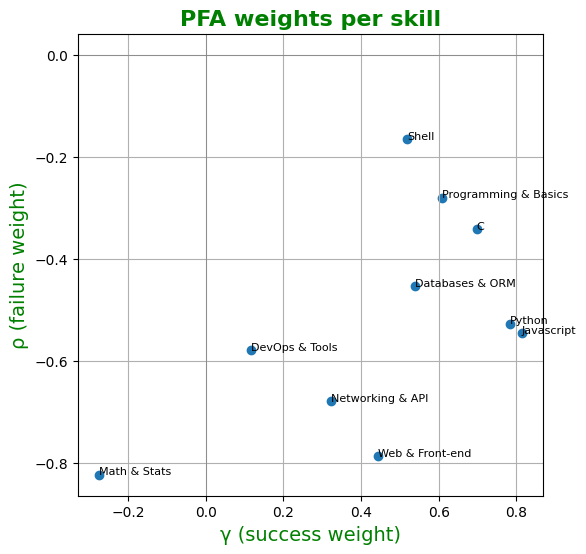

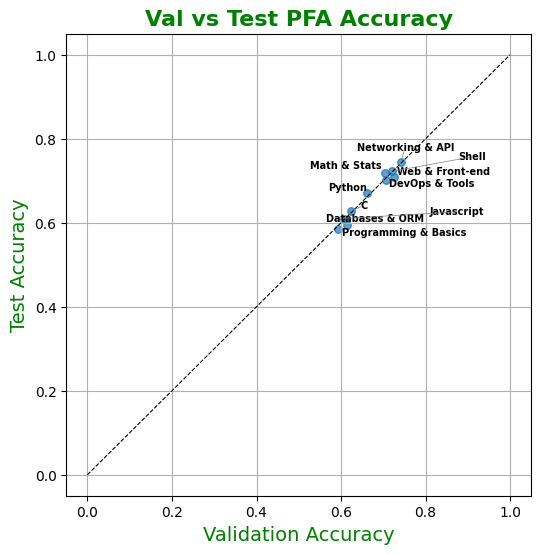

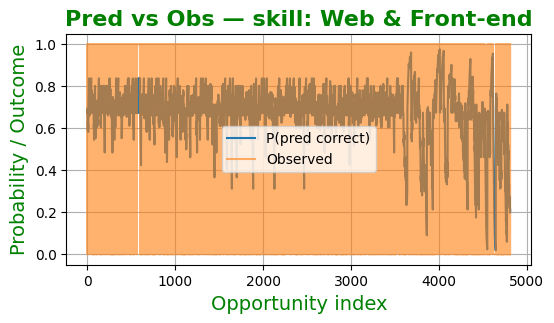

In [14]:
from adjustText import adjust_text

# 1) Coefficients per skill
coef_df = []
for skill, (pfa, _) in pfa_models.items():
    # here we use directly the attributes of the class
    b0, bs, bf = pfa.beta0, pfa.beta_s, pfa.beta_f
    coef_df.append((skill, b0, bs, bf))

coef_df = pd.DataFrame(coef_df, columns=['skill','intercept','gamma','rho'])

plt.figure(figsize=(6,6))
plt.scatter(coef_df['gamma'], coef_df['rho'])
for _, row in coef_df.iterrows():
    plt.text(row['gamma'], row['rho'], row['skill'], fontsize=8)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.xlabel("γ (success weight)", fontsize=14, color="Green")
plt.ylabel("ρ (failure weight)", fontsize=14, color="Green")
plt.title("PFA weights per skill", fontsize=16, fontweight="bold", color="Green")
plt.grid(True)
# Save the plot as an image
plt.savefig(f"images/pfa_weights_per_skill.png", dpi=300, bbox_inches='tight')

plt.show()

# 2) Validation vs Test accuracy
plt.figure(figsize=(6,6))
merged = val_df_acc.set_index('skill').join(test_df_acc.set_index('skill'), lsuffix='_val', rsuffix='_test')
x = merged['val_acc']
y = merged['test_acc']
plt.scatter(x, y, s=30, alpha=0.7)
plt.plot([0,1], [0,1], 'k--', lw=0.8)

# Creamos una lista de objetos Text
texts = []
for skill in merged.index:
    txt = plt.text(x.loc[skill], y.loc[skill], skill,
                   fontsize=7, weight='bold')
    texts.append(txt)

# Ajustamos las etiquetas para que no colisionen
adjust_text(texts,
            only_move={'points':'y', 'texts':'y'},
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
            expand_text=(1.05, 1.2),
            force_text=0.2,
            force_points=0.2)

plt.xlabel("Validation Accuracy", fontsize=14, color="Green")
plt.ylabel("Test Accuracy", fontsize=14, color="Green")
plt.title("Val vs Test PFA Accuracy", fontsize=16, fontweight="bold", color="Green")
plt.grid(True)
# Save the plot as an image
plt.savefig("images/val_vs_test_accuracy.png", dpi=300, bbox_inches='tight')

plt.show()

# 3) Example of predicted vs. correct curve
example_skill = test_df_acc.iloc[3]['skill']
sub = test_feat[test_feat['general_cat']==example_skill]
X_raw = sub[['succ_count','fail_count']].values.astype(float)
X_scaled = pfa_models[example_skill][1].transform(X_raw)
succ_s, fail_s = X_scaled[:,0], X_scaled[:,1]
probs = pfa_models[example_skill][0].predict_proba(succ_s, fail_s)

plt.figure(figsize=(6,3))
plt.plot(probs, label='P(pred correct)')
plt.plot(sub['correct'].astype(int).values, label='Observed', alpha=0.6)
plt.xlabel("Opportunity index", fontsize=14, color="Green")
plt.ylabel("Probability / Outcome", fontsize=14, color="Green")
plt.title(f"Pred vs Obs — skill: {example_skill}", fontsize=16, fontweight="bold", color="Green")
plt.legend()
plt.grid(True)
# Save the plot as an image
plt.savefig(f"images/pred_vs_obs_{example_skill}.png", dpi=300, bbox_inches='tight')

plt.show()

### Interpretation of the last 3 graphs

1. **Weights γ vs ρ per skill**.
   - Each point represents a skill (*skill*), with its success weight γ on the X-axis and its failure weight ρ on the Y-axis.  
   - We observe that most skills have γ > 0 (the number of previous successes increases the probability of success) and ρ < 0 (previous failures reduce it).  
   - Skills with ρ close to zero indicate that failures have little effect, while very negative values suggest that an error strongly penalizes the prediction.

2. **Validation vs Test: comparative accuracies**.
   - The scatter plot of '*val_acc vs test_acc*' by skill shows how stable the performance is: points close to the line y = x indicate that the model generalizes well.  
   - Some skills (e.g., *Networking & API*) perform consistently high on both splits (~0.74 val, 0.75 test), while others (e.g., *Programming & Basics*) fall on both (~0.59 val, 0.58 test), suggesting difference in complexity between skills.

3. **Example "Pred vs Obs" for a skill**.
   - The curve of predicted probabilities (line) vs. observed outcomes (0/1 points) across opportunities illustrates how the PFA model adapts its confidence after each hit or miss.  
   - One sees, typically, a gradual increase in probability when there are more successes and decreases after errors, showing that the model picks up the learning dynamics of that *skill*.

## 10. Conclusion

In this notebook we have implemented the *Performance Factors Analysis* (PFA) model to predict a student's probability of success as a function of his or her previous successes and failures on a skill. Through a logistic regression approach, we have trained skill-specific models and evaluated their performance on validation and test sets.
Below, we summarize the findings and limitations of the model, as well as next steps for future improvements.

### Key findings
- **Variable performance by skill**: Test accuracies range from ~0.58 to ~0.75, with *Networking & API*, *Shell* and *Math & Stats* being the most predictable.
- **AUC**: The model achieves a mean AUC of 0.709, indicating moderate discriminative power between correct and incorrect responses.
- **Consistent coefficients**: γ>0 and ρ<0 confirm that PFA correctly captures that prior successes increase the probability of success and failures decrease it.  
- **Good Val/Test correspondence**: Most skills show very similar accuracies in validation and test, indicating absence of significant overfitting.

### Limitations
- **Moderate overall Accuracy (≈ 0.65)**: While exceeding a random baseline, it falls far short of desirable levels for critical applications.  
- **Question difficulty not included**: Bias could occur if certain quizzes are systematically easier or harder and not modeled.  
- Separate models by skill**: Ignores possible correlations between skills (e.g., conceptual overlap between Python and Shell).

### Next steps
1. **Incorporate covariates**: Add *question difficulty*, *response time* or *not_focus_duration* features to refine predictions.  
2. **Multilevel models**: Test hierarchical or *multi-task learning* approaches that share information across skills.  
3. **Comparison with sequential models**: Contrast PFA with DKT/SAKT/AKT or Bayesian variants to assess improvements in capturing temporal dependence.  
4. **Threshold assessment**: Optimize decision thresholds by skill (e.g. cutoff grid-search) to maximize F1 or ROC curve.  
5. **Temporal cross-validation**: Implement *time-based CV* to verify robustness in streaming data scenarios.  